In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
import seaborn as sns
from pylab import rcParams
from collections import Counter
import tensorflow as tf
from tensorflow.keras import Model ,models, layers, optimizers, regularizers

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from keras.layers import Input

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model

In [2]:
raw_data = pd.read_csv('/content/drive/MyDrive/번천/dataset/train_data.csv')
raw_test = pd.read_csv('/content/drive/MyDrive/번천/dataset/test_data.csv')

In [3]:
raw_data.head()

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type
0,1.59,41.00,0.7,20.53,1680.0,58.67,2.93,0
1,2.97,59.28,0.7,38.40,3142.0,74.91,3.75,0
2,1.91,45.29,0.7,24.73,2023.0,62.48,3.12,0
3,2.37,51.33,0.7,30.63,2506.0,67.84,3.39,0
4,1.90,45.21,0.7,24.65,2017.0,62.41,3.12,0


In [4]:
raw_data['type'].value_counts()

0    432
1    369
2    366
3    306
4    306
5    249
6    249
7    186
Name: type, dtype: int64

In [5]:
raw_test['type'].value_counts()

0    1296
1    1107
2    1098
3     918
4     918
5     747
6     747
7     558
Name: type, dtype: int64

In [6]:
## 공기압추기가 돌아가는 순서로 열 새롭게 구성

train_data = raw_data[['air_inflow', 'motor_current','motor_rpm', 'motor_temp', 'motor_vibe', 'out_pressure', 'air_end_temp', 'type']].copy()
test_data = raw_test[['air_inflow', 'motor_current','motor_rpm', 'motor_temp', 'motor_vibe', 'out_pressure', 'air_end_temp', 'type']].copy()

설비 번호 [0, 4, 5, 6, 7]: 30HP(마력)

설비 번호 1: 20HP

설비 번호 2: 10HP

설비 번호 3: 50HP

In [7]:
hp30 = [0, 4, 5, 6, 7]
hp20 = [1]
hp10 = [2]
hp50 = [3]

In [8]:
# 설비별 데이터 세트 분리

train_data_30hp = train_data[train_data['type'].isin(hp30)].copy()
train_data_20hp = train_data[train_data['type'].isin(hp20)].copy()
train_data_10hp = train_data[train_data['type'].isin(hp10)].copy()
train_data_50hp = train_data[train_data['type'].isin(hp50)].copy()

In [9]:
# 설비별 데이터 세트 분리

test_data_30hp = test_data[test_data['type'].isin(hp30)].copy()
test_data_20hp = test_data[test_data['type'].isin(hp20)].copy()
test_data_10hp = test_data[test_data['type'].isin(hp10)].copy()
test_data_50hp = test_data[test_data['type'].isin(hp50)].copy()

# 모델 생성

In [ ]:
# # define the autoencoder network model
# def autoencoder_model(X):
#     inputs = Input(shape=(X.shape[1], X.shape[2]))
#     L1 = LSTM(16, activation='relu', return_sequences=True, 
#               kernel_regularizer=regularizers.l2(0.00))(inputs)
#     L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
#     L3 = RepeatVector(X.shape[1])(L2)
#     L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
#     L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
#     output = TimeDistributed(Dense(X.shape[2]))(L5)    
#     model = Model(inputs=inputs, outputs=output)
#     return model

In [10]:
timesteps = 3
n_features = 7
layer_1 = 32
layer_2 = 16

In [11]:
class lstm_ae(tf.keras.Model):
  def __init__(self, timesteps, n_features, layer_1, layer_2):
    super(lstm_ae).__init__()
    self.n_features = n_features
    self.timesteps = timesteps
    self.layer_1 = layer_1
    self.layer_2 = layer_2


  def encoder(self, x):
    x = layers.LSTM(self.layer_1, activation = 'tanh', return_sequences = True)(x)
    x = layers.LSTM(self.layer_2, activation = 'tanh', return_sequences = False)(x)
    en_output = layers.RepeatVector(self.timesteps)(x)
    return en_output

  def decoder(self, x):
    x = layers.LSTM(self.layer_2, activation = 'tanh', return_sequences = True)(x)
    x = layers.LSTM(self.layer_1, activation = 'tanh', return_sequences = True)(x)
    de_output = layers.TimeDistributed(layers.Dense(self.n_features))(x)

    return de_output

  def build(self):
    inputs = Input(shape = (self.timesteps, self.n_features))
    encoder = self.encoder(inputs)
    decoder = self.decoder(encoder)

    return Model(inputs, decoder)

# hp30

In [ ]:
def parallel(for_view, num):
  parallel_coordinates(frame = for_view[for_view['type'].isin(num)], class_column = 'type', colormap = plt.get_cmap('Set1'));

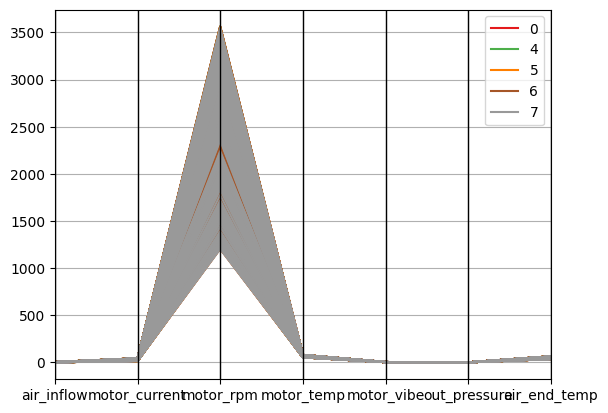

In [ ]:
parallel(train_data, hp30)

In [ ]:
scaler_30hp = StandardScaler()

# 설비 라벨 제외하여 train data로 정규화
train_scale_30hp = scaler_30hp.fit_transform(train_data_30hp.drop(['type'], axis=1))
test_scale_30hp = scaler_30hp.transform(test_data_30hp.drop(['type'], axis=1))

In [ ]:
# lstm 구조에 맞게 데이터 변형

def slicing(X, lookback):
    output_X = []
    # output_y = []
    for i in range(len(X) - lookback +1):
        t = []
        for j in range(0, lookback):
            t.append(X[(i + j), :])
        output_X.append(t)
    return np.array(output_X)

In [ ]:
# LTSM 구조에 맞게 데이터 변형
test_slice_30hp = slicing(test_scale_30hp,3)
train_slice_30hp = slicing(train_scale_30hp,3)

# 모델 학습을 위해 데이터 합치기
sum_slice_30hp = np.concatenate((test_slice_30hp, train_slice_30hp), axis=0)
sum_slice_30hp.shape

(5684, 3, 7)

In [ ]:
# X_train, X_test = train_test_split(train_slice_30hp, test_size=0.2, random_state=123)

In [ ]:
lstm_ae_30hp = lstm_ae(timesteps, n_features, layer_1, layer_2).build()

lstm_ae_30hp.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 3, 7)]            0         
                                                                 
 lstm_12 (LSTM)              (None, 3, 32)             5120      
                                                                 
 lstm_13 (LSTM)              (None, 16)                3136      
                                                                 
 repeat_vector_3 (RepeatVect  (None, 3, 16)            0         
 or)                                                             
                                                                 
 lstm_14 (LSTM)              (None, 3, 16)             2112      
                                                                 
 lstm_15 (LSTM)              (None, 3, 32)             6272      
                                                           

In [ ]:
lstm_ae_30hp.compile(optimizer = 'adam', loss = 'mse')

In [ ]:
## lr 계획과 모델 저장 코드
    
reduceLR = ReduceLROnPlateau(monitor='val_loss',
                             factor=.5,
                             patience=20,
                             verbose=1,
                             mode = 'min'
                             )
modelCheckpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/번천/모델 3/모델 저장/30hp.h5',
                                                  monitor='val_loss',
                                                  save_best_only=True,
                                                  verbose = 1)
callbacks_list = [reduceLR, modelCheckpoint]

In [ ]:
history = lstm_ae_30hp.fit(sum_slice_30hp, sum_slice_30hp,
                           epochs=200, batch_size=32,
                           validation_data=(train_slice_30hp, train_slice_30hp),
                           callbacks=callbacks_list)

Epoch 1/200
174/178 [============================>.] - ETA: 0s - loss: 0.6611
Epoch 1: val_loss improved from inf to 0.51437, saving model to /content/drive/MyDrive/번천/모델 3/모델 저장/30hp.h5
178/178 [==============================] - 7s 16ms/step - loss: 0.6585 - val_loss: 0.5144 - lr: 0.0010
Epoch 2/200
178/178 [==============================] - ETA: 0s - loss: 0.3376
Epoch 2: val_loss improved from 0.51437 to 0.21906, saving model to /content/drive/MyDrive/번천/모델 3/모델 저장/30hp.h5
178/178 [==============================] - 2s 13ms/step - loss: 0.3376 - val_loss: 0.2191 - lr: 0.0010
Epoch 3/200
176/178 [============================>.] - ETA: 0s - loss: 0.1131
Epoch 3: val_loss improved from 0.21906 to 0.05697, saving model to /content/drive/MyDrive/번천/모델 3/모델 저장/30hp.h5
178/178 [==============================] - 2s 14ms/step - loss: 0.1125 - val_loss: 0.0570 - lr: 0.0010
Epoch 4/200
177/178 [============================>.] - ETA: 0s - loss: 0.0316
Epoch

In [ ]:
np.save('/content/drive/MyDrive/번천/모델 3/30hp_history.npy',history.history)

In [ ]:
## 저장한 model과 history 불러오기

lstm_ae_30hp = load_model('/content/drive/MyDrive/번천/모델 3/모델 저장/30hp.h5')
history = history=np.load('/content/drive/MyDrive/번천/모델 3/30hp_history.npy',allow_pickle='TRUE').item()

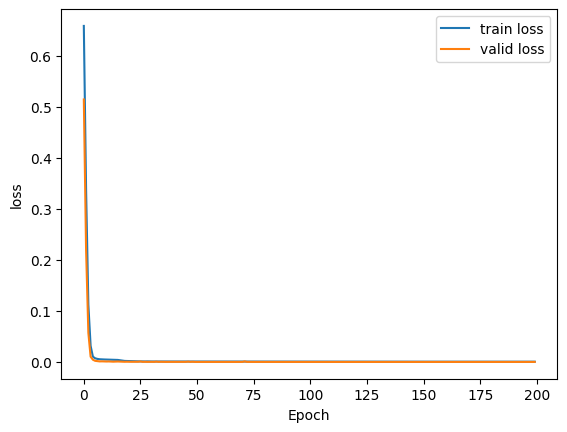

In [ ]:
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

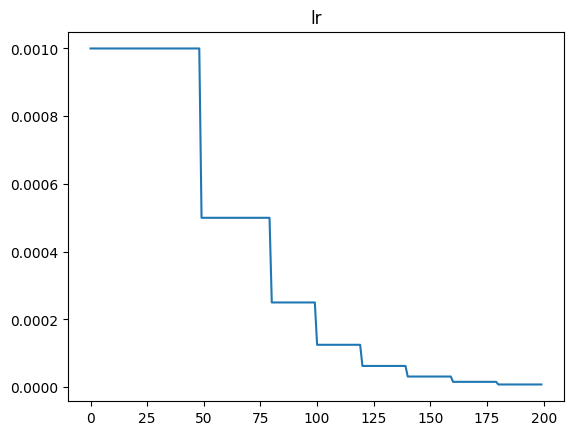

In [ ]:
plt.title('lr')
plt.plot(history['lr'], label='train')
plt.show()

In [ ]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

In [ ]:
pred_train_30hp = lstm_ae_30hp.predict(train_slice_30hp)

45/45 [==============================] - 1s 3ms/step


In [ ]:
train_mse_30hp = np.mean(np.square(flatten(train_slice_30hp) - flatten(pred_train_30hp)), axis =1 )
threshold_30hp = np.max(train_mse_30hp)
print(threshold_30hp)

0.00018122399022083138


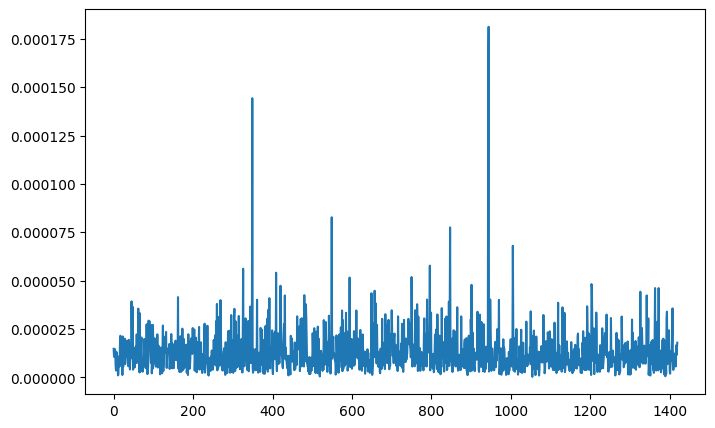

In [ ]:
plt.figure(figsize = (8,5))
plt.plot(train_mse_30hp)

In [ ]:
test_slice_30hp = slicing(test_scale_30hp,3)

In [ ]:
pred_test_30hp = lstm_ae_30hp.predict(test_slice_30hp)

134/134 [==============================] - 0s 3ms/step


In [ ]:
test_mse_30hp = np.mean(np.square(flatten(test_slice_30hp) - flatten(pred_test_30hp)), axis =1 )

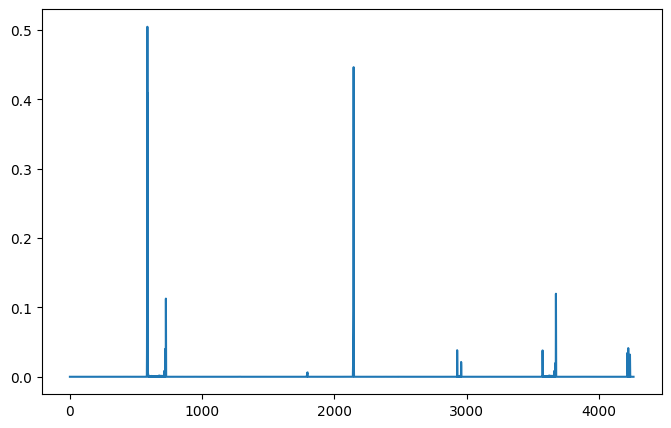

In [ ]:
plt.figure(figsize = (8,5))
plt.plot(test_mse_30hp)
# plt.ylim(0, 0.005)

In [ ]:
anom_30hp = test_mse_30hp > threshold_30hp
np.sum(anom_30hp)

257

In [ ]:
test_data_30hp

,air_inflow,motor_current,motor_rpm,motor_temp,motor_vibe,out_pressure,air_end_temp,type
0,2.51,32.54,2662.0,69.58,3.48,0.7,53.28,0
1,2.66,34.45,2819.0,71.32,3.57,0.7,55.24,0
2,1.72,22.23,1819.0,60.21,3.01,0.7,42.74,0
3,2.20,28.50,2332.0,65.91,3.30,0.7,49.15,0
4,2.06,26.67,2182.0,64.24,3.21,0.7,47.28,0
...,...,...,...,...,...,...,...,...
7384,2.12,27.45,2246.0,64.96,3.25,0.7,48.08,7
7385,1.48,19.19,1570.0,57.44,2.87,0.7,39.63,7
7386,1.56,20.15,1649.0,58.32,2.92,0.7,40.61,7
7387,1.59,20.52,1679.0,58.66,2.93,0.7,40.99,7


In [ ]:
def plus(anom):
  if anom[0] == 0:
    return [0,0] + list(anom*1)
  else:
    return [0,1] + list(anom*1)

In [ ]:
pred_30hp = test_data_30hp.copy()
pred_30hp['y'] = plus(anom_30hp)

In [ ]:
pred_30hp['y']

0       0
1       0
2       0
3       0
4       0
       ..
7384    0
7385    0
7386    0
7387    0
7388    0
Name: y, Length: 4266, dtype: int64

# hp20

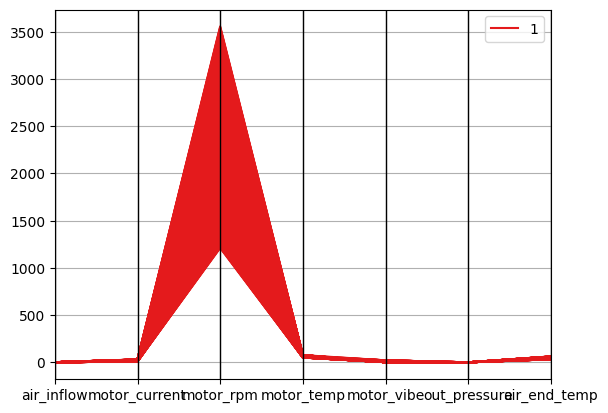

In [ ]:
parallel(train_data, hp20)

이전 모델에서 train의 126 ~ 164 까지의 데이터는 이상 데이터로 판단

In [ ]:
first = 126
last = 164

new_train_20hp = pd.concat([train_data_20hp.iloc[:first], train_data_20hp.iloc[last + 1:]])

In [ ]:
scaler_20hp = StandardScaler()

# 설비 라벨 제외하여 train data로 정규화
train_scale_20hp = scaler_20hp.fit_transform(new_train_20hp.drop(['type'], axis=1))
test_scale_20hp = scaler_20hp.transform(test_data_20hp.drop(['type'], axis=1))

In [ ]:
# lstm 구조에 맞게 데이터 변형

def slicing(X, lookback):
    output_X = []
    # output_y = []
    for i in range(len(X) - lookback +1):
        t = []
        for j in range(0, lookback):
            t.append(X[(i + j), :])
        output_X.append(t)
    return np.array(output_X)

In [ ]:
# LTSM 구조에 맞게 데이터 변형
test_slice_20hp = slicing(test_scale_20hp,3)
train_slice_20hp = slicing(train_scale_20hp,3)

# 모델 학습을 위해 데이터 합치기
sum_slice_20hp = np.concatenate((test_slice_20hp, train_slice_20hp), axis=0)
sum_slice_20hp.shape

(1433, 3, 7)

In [ ]:
lstm_ae_20hp = lstm_ae(timesteps, n_features, layer_1, layer_2).build()
lstm_ae_20hp.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 3, 7)]            0         
                                                                 
 lstm_16 (LSTM)              (None, 3, 32)             5120      
                                                                 
 lstm_17 (LSTM)              (None, 16)                3136      
                                                                 
 repeat_vector_4 (RepeatVect  (None, 3, 16)            0         
 or)                                                             
                                                                 
 lstm_18 (LSTM)              (None, 3, 16)             2112      
                                                                 
 lstm_19 (LSTM)              (None, 3, 32)             6272      
                                                           

In [ ]:
lstm_ae_20hp.compile(optimizer = 'adam', loss = 'mse')

In [ ]:
## lr 계획과 모델 저장 코드
    
reduceLR = ReduceLROnPlateau(monitor='val_loss',
                             factor=.5,
                             patience=20,
                             verbose=1,
                             mode = 'min'
                             )
modelCheckpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/번천/모델 3/모델 저장/20hp.h5',
                                                  monitor='val_loss',
                                                  save_best_only=True,
                                                  verbose = 1)
callbacks_list = [reduceLR, modelCheckpoint]

In [ ]:
history = lstm_ae_20hp.fit(sum_slice_20hp, sum_slice_20hp,
                           epochs=200, batch_size=32,
                           validation_data=(train_slice_20hp, train_slice_20hp),
                           callbacks=callbacks_list)

Epoch 1/200
45/45 [==============================] - ETA: 0s - loss: 0.8793
Epoch 1: val_loss improved from inf to 0.77732, saving model to /content/drive/MyDrive/번천/모델 3/모델 저장/20hp.h5
45/45 [==============================] - 11s 40ms/step - loss: 0.8793 - val_loss: 0.7773 - lr: 0.0010
Epoch 2/200
42/45 [===========================>..] - ETA: 0s - loss: 0.7040
Epoch 2: val_loss improved from 0.77732 to 0.56410, saving model to /content/drive/MyDrive/번천/모델 3/모델 저장/20hp.h5
45/45 [==============================] - 1s 12ms/step - loss: 0.6980 - val_loss: 0.5641 - lr: 0.0010
Epoch 3/200
42/45 [===========================>..] - ETA: 0s - loss: 0.5874
Epoch 3: val_loss improved from 0.56410 to 0.54554, saving model to /content/drive/MyDrive/번천/모델 3/모델 저장/20hp.h5
45/45 [==============================] - 0s 11ms/step - loss: 0.5855 - val_loss: 0.5455 - lr: 0.0010
Epoch 4/200
40/45 [=========================>....] - ETA: 0s - loss: 0.5655
Epoch 4: val_loss 

In [ ]:
np.save('/content/drive/MyDrive/번천/모델 3/20hp_history.npy',history.history)

In [12]:
## 저장한 model과 history 불러오기

lstm_ae_20hp = load_model('/content/drive/MyDrive/번천/모델 3/모델 저장/20hp.h5')
history = history=np.load('/content/drive/MyDrive/번천/모델 3/20hp_history.npy',allow_pickle='TRUE').item()

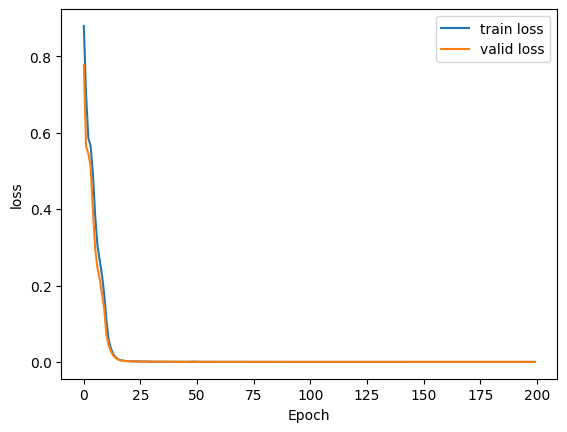

In [13]:
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

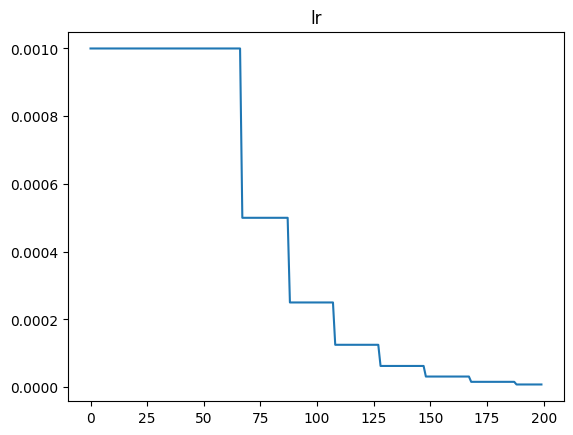

In [14]:
plt.title('lr')
plt.plot(history['lr'], label='train')
plt.show()

In [15]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

In [16]:
pred_train_20hp = lstm_ae_20hp.predict(train_slice_20hp)

NameError: ignored

In [ ]:
train_mse_20hp = np.mean(np.square(flatten(train_slice_20hp) - flatten(pred_train_20hp)), axis =1 )
threshold_20hp = np.mean(train_mse_20hp)+ 5*np.std(train_mse_20hp)
print(threshold_20hp)

0.005035326994879765


(0.0, 0.05)

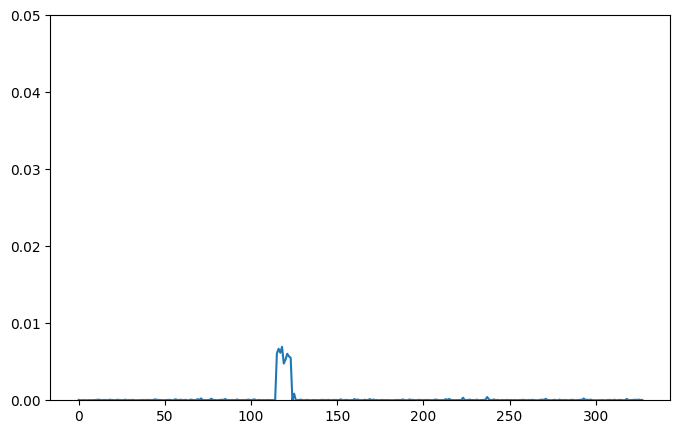

In [ ]:
plt.figure(figsize = (8,5))
plt.plot(train_mse_20hp)
plt.ylim(0, 0.05)

In [ ]:
pred_test_20hp = lstm_ae_20hp.predict(test_slice_20hp)

35/35 [==============================] - 0s 3ms/step


In [ ]:
test_mse_20hp = np.mean(np.square(flatten(test_slice_20hp) - flatten(pred_test_20hp)), axis =1 )

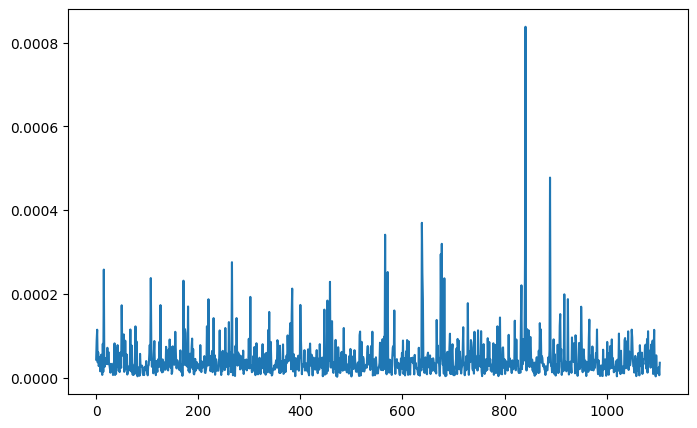

In [ ]:
plt.figure(figsize = (8,5))
plt.plot(test_mse_20hp)

In [ ]:
anom_20hp = test_mse_20hp > threshold_20hp
np.sum(anom_20hp)

0

In [ ]:
test_data_20hp

,air_inflow,motor_current,motor_rpm,motor_temp,motor_vibe,out_pressure,air_end_temp,type
1296,1.95,28.81,3346.0,75.18,3.66,0.7,59.83,1
1297,0.74,10.91,1267.0,52.08,2.50,0.7,33.84,1
1298,0.97,14.31,1662.0,56.47,2.72,0.7,38.78,1
1299,2.05,30.31,3520.0,77.11,3.76,0.7,62.00,1
1300,1.60,23.62,2743.0,68.48,3.32,0.7,52.29,1
...,...,...,...,...,...,...,...,...
2398,1.01,14.85,1725.0,57.17,2.76,0.7,39.56,1
2399,1.05,15.46,1795.0,57.94,2.80,0.7,40.44,1
2400,1.67,24.70,2868.0,69.87,3.39,0.7,53.85,1
2401,0.84,12.39,1439.0,53.99,2.60,0.7,35.99,1


In [ ]:
def plus(anom):
  if anom[0] == 0:
    return [0,0] + list(anom*1)
  else:
    return [0,1] + list(anom*1)


In [ ]:
pred_20hp = test_data_20hp.copy()
pred_20hp['y'] = plus(anom_20hp)

In [ ]:
pred_20hp['y']

1296    0
1297    0
1298    0
1299    0
1300    0
       ..
2398    0
2399    0
2400    0
2401    0
2402    0
Name: y, Length: 1107, dtype: int64

맞지 않은 데이터 제거 필요

# hp10


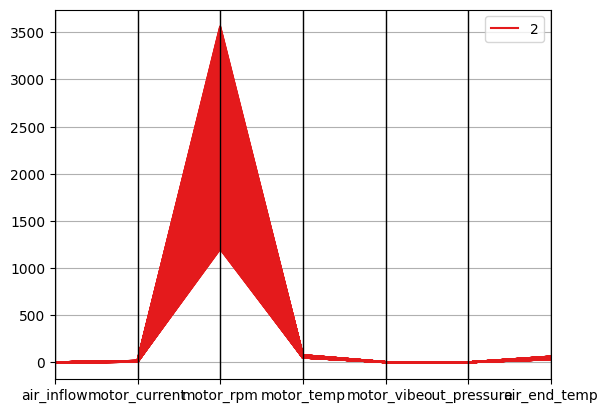

In [ ]:
parallel(train_data, hp10)

In [ ]:
scaler_10hp = StandardScaler()

# 설비 라벨 제외
train_scale_10hp = scaler_10hp.fit_transform(train_data_10hp.drop(['type'], axis=1))
test_scale_10hp = scaler_10hp.transform(test_data_10hp.drop(['type'], axis=1))

In [ ]:
train_scale_10hp.shape

(366, 7)

In [ ]:
# lstm 구조에 맞게 데이터 변형

def slicing(X, lookback):
    output_X = []
    # output_y = []
    for i in range(len(X) - lookback +1):
        t = []
        for j in range(0, lookback):
            t.append(X[(i + j), :])
        output_X.append(t)
    return np.array(output_X)

In [ ]:
# LTSM 구조에 맞게 데이터 변형
test_slice_10hp = slicing(test_scale_10hp,3)
train_slice_10hp = slicing(train_scale_10hp,3)

# 모델 학습을 위해 데이터 합치기
sum_slice_10hp = np.concatenate((test_slice_10hp, train_slice_10hp), axis=0)
sum_slice_10hp.shape

(1460, 3, 7)

In [ ]:
lstm_ae_10hp = lstm_ae(timesteps, n_features, layer_1, layer_2).build()

lstm_ae_10hp.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 3, 7)]            0         
                                                                 
 lstm_20 (LSTM)              (None, 3, 32)             5120      
                                                                 
 lstm_21 (LSTM)              (None, 16)                3136      
                                                                 
 repeat_vector_5 (RepeatVect  (None, 3, 16)            0         
 or)                                                             
                                                                 
 lstm_22 (LSTM)              (None, 3, 16)             2112      
                                                                 
 lstm_23 (LSTM)              (None, 3, 32)             6272      
                                                           

In [ ]:
lstm_ae_10hp.compile(optimizer = 'adam', loss = 'mse')

In [ ]:
## lr 계획과 모델 저장 코드
    
reduceLR = ReduceLROnPlateau(monitor='val_loss',
                             factor=.5,
                             patience=20,
                             verbose=1,
                             mode = 'min'
                             )
modelCheckpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/번천/모델 3/모델 저장/10hp.h5',
                                                  monitor='val_loss',
                                                  save_best_only=True,
                                                  verbose = 1)
callbacks_list = [reduceLR, modelCheckpoint]

In [ ]:
history = lstm_ae_10hp.fit(sum_slice_10hp, sum_slice_10hp,
                           epochs=200, batch_size=32,
                           validation_data=(train_slice_10hp, train_slice_10hp),
                           callbacks=callbacks_list)

Epoch 1/200
42/46 [==========================>...] - ETA: 0s - loss: 0.8529
Epoch 1: val_loss improved from inf to 0.77455, saving model to /content/drive/MyDrive/번천/모델 3/모델 저장/10hp.h5
46/46 [==============================] - 11s 39ms/step - loss: 0.8493 - val_loss: 0.7746 - lr: 0.0010
Epoch 2/200
42/46 [==========================>...] - ETA: 0s - loss: 0.6686
Epoch 2: val_loss improved from 0.77455 to 0.58173, saving model to /content/drive/MyDrive/번천/모델 3/모델 저장/10hp.h5
46/46 [==============================] - 0s 11ms/step - loss: 0.6640 - val_loss: 0.5817 - lr: 0.0010
Epoch 3/200
42/46 [==========================>...] - ETA: 0s - loss: 0.5697
Epoch 3: val_loss improved from 0.58173 to 0.56847, saving model to /content/drive/MyDrive/번천/모델 3/모델 저장/10hp.h5
46/46 [==============================] - 0s 11ms/step - loss: 0.5710 - val_loss: 0.5685 - lr: 0.0010
Epoch 4/200
42/46 [==========================>...] - ETA: 0s - loss: 0.5549
Epoch 4: val_loss 

In [ ]:
np.save('/content/drive/MyDrive/번천/모델 3/10hp_history.npy',history.history)

In [ ]:
## 저장한 model과 history 불러오기

lstm_ae_10hp = load_model('/content/drive/MyDrive/번천/모델 3/모델 저장/10hp.h5')
history = np.load('/content/drive/MyDrive/번천/모델 3/10hp_history.npy',allow_pickle='TRUE').item()

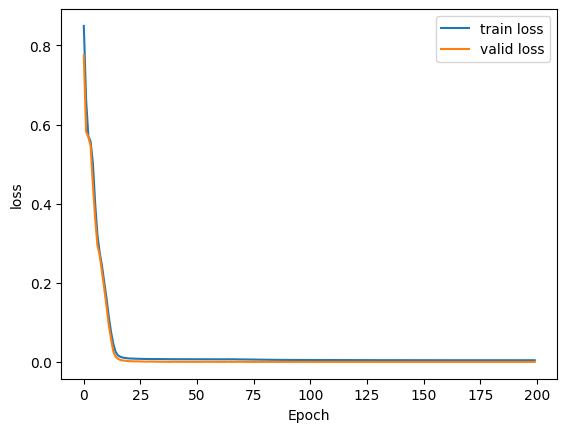

In [ ]:
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

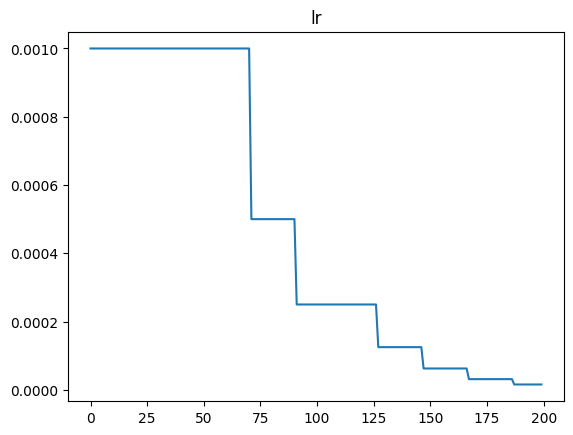

In [ ]:
plt.title('lr')
plt.plot(history['lr'], label='train')
plt.show()

In [ ]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

In [ ]:
pred_train_10hp = lstm_ae_10hp.predict(train_slice_10hp)

12/12 [==============================] - 2s 4ms/step


In [ ]:
train_mse_10hp = np.mean(np.square(flatten(train_slice_10hp) - flatten(pred_train_10hp)), axis =1 )
threshold_10hp = np.max(train_mse_10hp)  # np.mean(train_mse_10hp)+ 3*np.std(train_mse_10hp)
print(threshold_10hp)

0.0005208776533275319


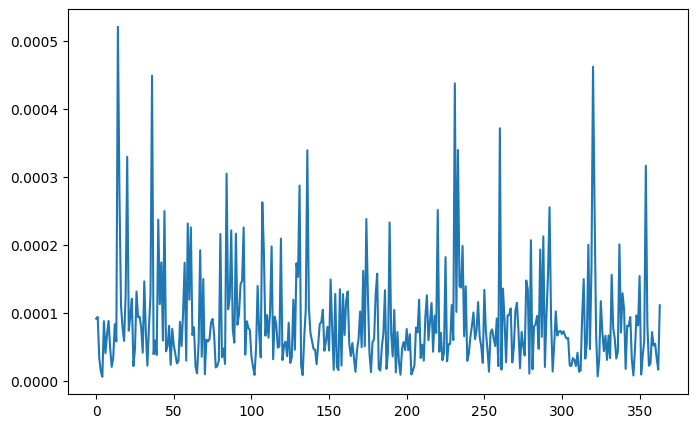

In [ ]:
plt.figure(figsize = (8,5))
plt.plot(train_mse_10hp)

In [ ]:
test_slice_10hp = slicing(test_scale_10hp,3)

In [ ]:
pred_test_10hp = lstm_ae_10hp.predict(test_slice_10hp)

35/35 [==============================] - 0s 3ms/step


In [ ]:
test_mse_10hp = np.mean(np.square(flatten(test_slice_10hp) - flatten(pred_test_10hp)), axis =1 )

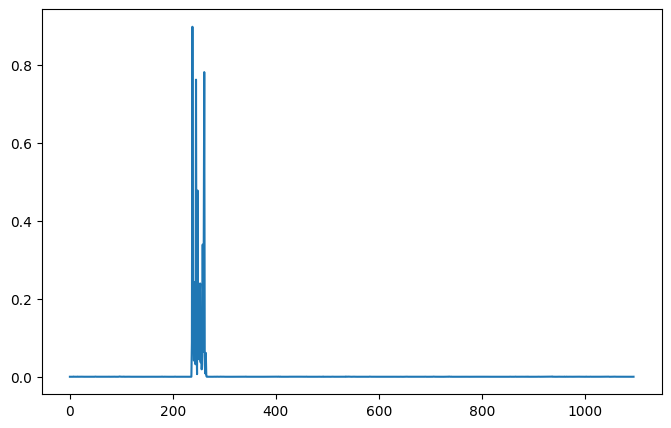

In [ ]:
plt.figure(figsize = (8,5))
plt.plot(test_mse_10hp)

In [ ]:
anom_10hp = test_mse_10hp > threshold_10hp
np.sum(anom_10hp)

35

In [ ]:
def plus(anom):
  if anom[0] == 0:
    return [0,0] + list(anom*1)
  else:
    return [0,1] + list(anom*1)

In [ ]:
pred_10hp = test_data_10hp.copy()
pred_10hp['y'] = plus(anom_10hp)

In [ ]:
pred_10hp['y']

2403    0
2404    0
2405    0
2406    0
2407    0
       ..
3496    0
3497    0
3498    0
3499    0
3500    0
Name: y, Length: 1098, dtype: int64

# hp50

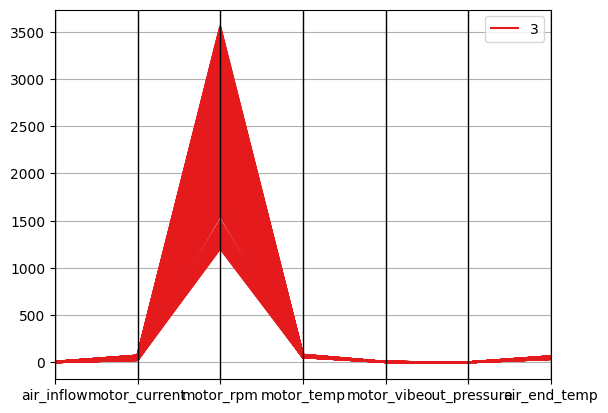

In [ ]:
parallel(train_data, hp50)

In [ ]:
scaler_50hp = StandardScaler()

# 설비 라벨 제외
train_scale_50hp = scaler_50hp.fit_transform(train_data_50hp.drop(['type'], axis=1))
test_scale_50hp = scaler_50hp.transform(test_data_50hp.drop(['type'], axis=1))

In [ ]:
# lstm 구조에 맞게 데이터 변형

def slicing(X, lookback):
    output_X = []
    # output_y = []
    for i in range(len(X) - lookback +1):
        t = []
        for j in range(0, lookback):
            t.append(X[(i + j), :])
        output_X.append(t)
    return np.array(output_X)

In [ ]:
# LTSM 구조에 맞게 데이터 변형
test_slice_50hp = slicing(test_scale_50hp,3)
train_slice_50hp = slicing(train_scale_50hp,3)

# 모델 학습을 위해 데이터 합치기
sum_slice_50hp = np.concatenate((test_slice_50hp, train_slice_50hp), axis=0)
sum_slice_50hp.shape

(1220, 3, 7)

In [ ]:
lstm_ae_50hp = lstm_ae(timesteps, n_features, layer_1, layer_2).build()

lstm_ae_50hp.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 3, 7)]            0         
                                                                 
 lstm_24 (LSTM)              (None, 3, 32)             5120      
                                                                 
 lstm_25 (LSTM)              (None, 16)                3136      
                                                                 
 repeat_vector_6 (RepeatVect  (None, 3, 16)            0         
 or)                                                             
                                                                 
 lstm_26 (LSTM)              (None, 3, 16)             2112      
                                                                 
 lstm_27 (LSTM)              (None, 3, 32)             6272      
                                                           

In [ ]:
lstm_ae_50hp.compile(optimizer = 'adam', loss = 'mse')

In [ ]:
## lr 계획과 모델 저장 코드
    
reduceLR = ReduceLROnPlateau(monitor='val_loss',
                             factor=.5,
                             patience=20,
                             verbose=1,
                             mode = 'min'
                             )
modelCheckpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/번천/모델 3/모델 저장/50hp.h5',
                                                  monitor='val_loss',
                                                  save_best_only=True,
                                                  verbose = 1)
callbacks_list = [reduceLR, modelCheckpoint]

In [ ]:
history = lstm_ae_50hp.fit(sum_slice_50hp, sum_slice_50hp,
                           epochs=200, batch_size=32,
                           validation_data=(train_slice_50hp, train_slice_50hp),
                           callbacks=callbacks_list)

Epoch 1/200
34/39 [=========================>....] - ETA: 0s - loss: 0.8629
Epoch 1: val_loss improved from inf to 0.81300, saving model to /content/drive/MyDrive/번천/모델 3/모델 저장/50hp.h5
39/39 [==============================] - 11s 70ms/step - loss: 0.8562 - val_loss: 0.8130 - lr: 0.0010
Epoch 2/200
33/39 [========================>.....] - ETA: 0s - loss: 0.7534
Epoch 2: val_loss improved from 0.81300 to 0.65144, saving model to /content/drive/MyDrive/번천/모델 3/모델 저장/50hp.h5
39/39 [==============================] - 0s 12ms/step - loss: 0.7415 - val_loss: 0.6514 - lr: 0.0010
Epoch 3/200
38/39 [============================>.] - ETA: 0s - loss: 0.6082
Epoch 3: val_loss improved from 0.65144 to 0.58495, saving model to /content/drive/MyDrive/번천/모델 3/모델 저장/50hp.h5
39/39 [==============================] - 1s 15ms/step - loss: 0.6087 - val_loss: 0.5849 - lr: 0.0010
Epoch 4/200
37/39 [===========================>..] - ETA: 0s - loss: 0.5828
Epoch 4: val_loss 

In [ ]:
np.save('/content/drive/MyDrive/번천/모델 3/50hp_history.npy',history.history)

In [ ]:
## 저장한 model과 history 불러오기

lstm_ae_50hp = load_model('/content/drive/MyDrive/번천/모델 3/모델 저장/50hp.h5')
history = history=np.load('/content/drive/MyDrive/번천/모델 3/50hp_history.npy',allow_pickle='TRUE').item()

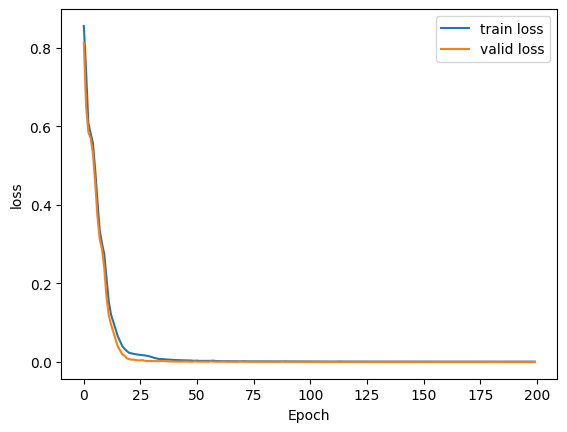

In [ ]:
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

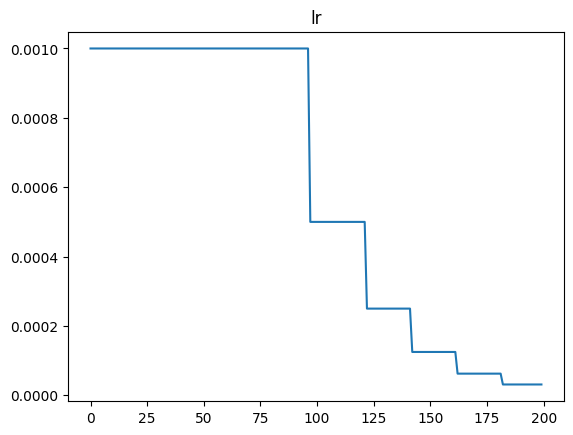

In [ ]:
plt.title('lr')
plt.plot(history['lr'], label='train')
plt.show()

In [ ]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

In [ ]:
pred_train_50hp = lstm_ae_50hp.predict(train_slice_50hp)

10/10 [==============================] - 2s 3ms/step


In [ ]:
train_mse_50hp = np.mean(np.square(flatten(train_slice_50hp) - flatten(pred_train_50hp)), axis =1 )
threshold_50hp = np.max(train_mse_50hp)
print(threshold_50hp)

0.00087424497043674


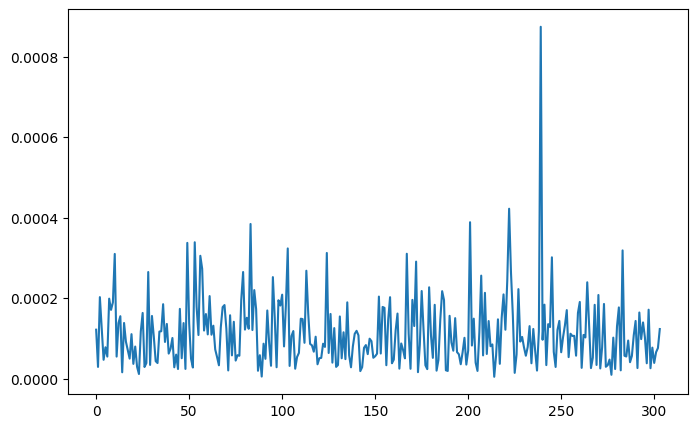

In [ ]:
plt.figure(figsize = (8,5))
plt.plot(train_mse_50hp)
# plt.ylim(0, 1)

In [ ]:
test_slice_50hp = slicing(test_scale_50hp,3)

In [ ]:
pred_test_50hp = lstm_ae_50hp.predict(test_slice_50hp)

29/29 [==============================] - 0s 5ms/step


In [ ]:
test_mse_50hp = np.mean(np.square(flatten(test_slice_50hp) - flatten(pred_test_50hp)), axis =1 )

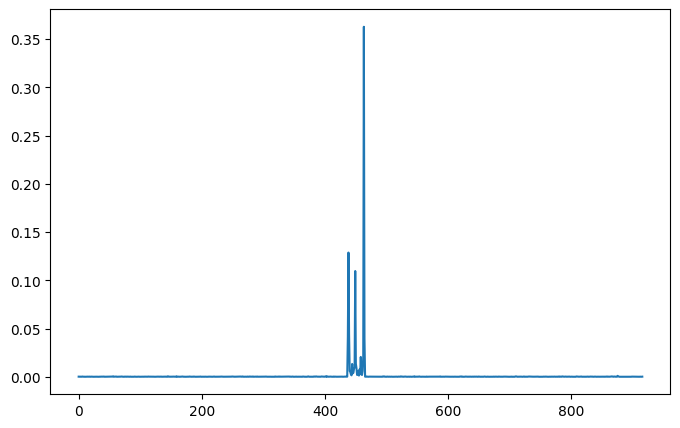

In [ ]:
plt.figure(figsize = (8,5))
plt.plot(test_mse_50hp)

In [ ]:
anom_50hp = test_mse_50hp > threshold_50hp
np.sum(anom_50hp)

29

In [ ]:
test_data_50hp

,air_inflow,motor_current,motor_rpm,motor_temp,motor_vibe,out_pressure,air_end_temp,type
3501,2.40,28.0,1374.0,56.27,3.96,0.7,37.68,3
3502,2.84,33.0,1625.0,59.06,4.10,0.7,40.81,3
3503,5.66,66.0,3236.0,76.96,5.00,0.7,60.95,3
3504,2.92,34.0,1667.0,59.52,4.13,0.7,41.34,3
3505,5.32,62.0,3039.0,74.77,4.89,0.7,58.49,3
...,...,...,...,...,...,...,...,...
4414,4.99,58.0,2852.0,72.69,4.78,0.7,56.15,3
4415,3.16,37.0,1805.0,61.06,4.20,0.7,43.06,3
4416,4.56,53.0,2603.0,69.92,4.65,0.7,53.04,3
4417,6.23,72.0,3560.0,80.56,5.18,0.7,65.00,3


In [ ]:
def plus(anom):
  if anom[0] == 0:
    return [0,0] + list(anom*1)
  else:
    return [0,1] + list(anom*1)


In [ ]:
pred_50hp = test_data_50hp.copy()
pred_50hp['y'] = plus(anom_50hp)

In [ ]:
pred_50hp['y']

3501    0
3502    0
3503    0
3504    0
3505    0
       ..
4414    0
4415    0
4416    0
4417    0
4418    0
Name: y, Length: 918, dtype: int64

# pred 합치기

test_data_30hp

test_data_20hp

test_data_10hp

test_data_50hp

In [ ]:
answer = pd.concat([pred_30hp['y'], pred_20hp['y'], pred_10hp['y'], pred_50hp['y']]).sort_index()
answer = pd.concat([test_data['type'], answer], axis=1)
answer.rename(columns={'y':'label'}, inplace = True)

In [ ]:
answer

,type,label
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
7384,7,0
7385,7,0
7386,7,0
7387,7,0


In [ ]:
answer.to_csv("/content/drive/MyDrive/번천/answer_model4.csv")